# EAGLE: Unsupervised Semantic Segmentation
## Final Demo - Quantitative & Qualitative Results

This notebook demonstrates EAGLE's pre-trained model on COCO-Stuff dataset.

**Steps:**
1. Setup environment
2. Download COCO-Stuff dataset
3. Download pre-trained EAGLE model
4. Run quantitative evaluation (mIoU, Accuracy)
5. Generate qualitative results (segmentation visualizations)

## Step 1: Setup Environment

In [1]:
# Install dependencies
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q pytorch-lightning==2.0.0 omegaconf scipy scikit-learn matplotlib seaborn tqdm gdown

print("Dependencies installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 48.8 MB/s eta 0:00:00
Dependencies installed!


In [2]:
# Setup paths
from pathlib import Path
import os

# Define directories
EAGLE_ROOT = Path("/content/EAGLE")
DATA_ROOT = Path("/content/data/cocostuff164k")
MODELS_DIR = EAGLE_ROOT / "models"

# Create directories
EAGLE_ROOT.mkdir(exist_ok=True)
DATA_ROOT.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

print(f"EAGLE_ROOT: {EAGLE_ROOT}")
print(f"DATA_ROOT: {DATA_ROOT}")
print(f"MODELS_DIR: {MODELS_DIR}")

EAGLE_ROOT: /content/EAGLE
DATA_ROOT: /content/data/cocostuff164k
MODELS_DIR: /content/EAGLE/models


## Step 2: Download EAGLE Repository

In [3]:
# Step 2: Download EAGLE Repository

import os
import shutil
from pathlib import Path

os.chdir("/content")

# Remove if exists (to ensure clean clone)
if EAGLE_ROOT.exists():
    print("Removing existing EAGLE directory...")
    shutil.rmtree(EAGLE_ROOT)

# Clone EAGLE repository
print("Cloning EAGLE repository from GitHub...")
!git clone https://github.com/MICV-yonsei/EAGLE.git

# Verify structure
if (EAGLE_ROOT / "src_EAGLE").exists():
    print("EAGLE repository cloned successfully")
    print("\nRepository structure:")
    !ls -la {EAGLE_ROOT}

    print("\nSource files:")
    !ls {EAGLE_ROOT}/src_EAGLE/ | head -10
else:
    print("Clone failed - src_EAGLE directory not found")

Removing existing EAGLE directory...
Cloning EAGLE repository from GitHub...
Cloning into 'EAGLE'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 90 (delta 25), reused 31 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 9.23 MiB | 14.13 MiB/s, done.
Resolving deltas: 100% (25/25), done.
EAGLE repository cloned successfully

Repository structure:
total 36
drwxr-xr-x 5 root root 4096 Nov 29 18:46 .
drwxr-xr-x 1 root root 4096 Nov 29 18:46 ..
-rw-r--r-- 1 root root  645 Nov 29 18:46 environment.yml
drwxr-xr-x 8 root root 4096 Nov 29 18:46 .git
drwxr-xr-x 2 root root 4096 Nov 29 18:46 img
-rw-r--r-- 1 root root 1068 Nov 29 18:46 LICENSE
-rw-r--r-- 1 root root 7116 Nov 29 18:46 README.md
drwxr-xr-x 5 root root 4096 Nov 29 18:46 src_EAGLE

Source files:
configs
crf.py
crop_datasets.py
data.py
dino
download_datasets.py
eigen_modules.py
eval_segmentation.py
modules.py
picie


## Step 3: Download COCO-Stuff Dataset

In [4]:
# Step 3: Download from Shared Google Drive Link
import gdown
import zipfile

# Your shared Drive links (anyone with link can access)
files_to_download = {
    "val2017.zip": "1fcOYoY16zH23K2jO7B3dPwGbobZY3TEe",
    "stuffthingmaps_trainval2017.zip": "1r9sjFsQazgaqpu8SMMKzZqeJY5hQleV1"
}

for filename, file_id in files_to_download.items():
    print(f"Downloading {filename}...")
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, filename, quiet=False)

    # Extract
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        if "val2017" in filename:
            zip_ref.extractall(str(DATA_ROOT / "images"))
        else:
            zip_ref.extractall(str(DATA_ROOT / "annotations"))

    print(f"{filename} extracted")

print("\nDataset ready!")

Downloading...
From (original): https://drive.google.com/uc?id=1fcOYoY16zH23K2jO7B3dPwGbobZY3TEe
From (redirected): https://drive.google.com/uc?id=1fcOYoY16zH23K2jO7B3dPwGbobZY3TEe&confirm=t&uuid=3bf4e406-6ef9-49a6-9e05-1596ce80d345
To: /content/val2017.zip
100%|██████████| 816M/816M [00:03<00:00, 223MB/s]


val2017.zip extracted


Downloading...
From (original): https://drive.google.com/uc?id=1r9sjFsQazgaqpu8SMMKzZqeJY5hQleV1
From (redirected): https://drive.google.com/uc?id=1r9sjFsQazgaqpu8SMMKzZqeJY5hQleV1&confirm=t&uuid=c993e7f6-fcba-423d-87d6-9ea0d58f02f3
To: /content/stuffthingmaps_trainval2017.zip
100%|██████████| 659M/659M [00:02<00:00, 241MB/s]


stuffthingmaps_trainval2017.zip extracted

Dataset ready!


## Step 4: Setup Dataset Structure for EAGLE

In [5]:
# Create directory structure expected by EAGLE
from pathlib import Path
import os

# Create curated directory structure
curated_dir = DATA_ROOT / "cocostuff" / "curated" / "val2017"
curated_dir.mkdir(parents=True, exist_ok=True)

# Create image list file
val_images_dir = DATA_ROOT / "images" / "val2017"
val_images = sorted([f.stem for f in val_images_dir.glob("*.jpg")])

image_list_file = curated_dir / "Coco164kFull_Stuff_Coarse_7.txt"
with open(image_list_file, 'w') as f:
    for img_id in val_images:
        f.write(f"{img_id}\n")

# Create symbolic links
cocostuff_dir = DATA_ROOT / "cocostuff"
images_link = cocostuff_dir / "images"
annotations_link = cocostuff_dir / "annotations"

if images_link.exists():
    images_link.unlink()
if annotations_link.exists():
    annotations_link.unlink()

os.symlink(DATA_ROOT / "images", images_link)
os.symlink(DATA_ROOT / "annotations", annotations_link)

print(f"Dataset structure created")
print(f"   Image list: {len(val_images)} images")
print(f"   Symbolic links created")

Dataset structure created
   Image list: 5000 images
   Symbolic links created


## Step 5: Download Pre-trained EAGLE Model

In [6]:
# Download pre-trained EAGLE checkpoint from Google Drive
import gdown
from pathlib import Path

pretrained_dir = EAGLE_ROOT / "pretrained"
pretrained_dir.mkdir(exist_ok=True)

pretrained_path = pretrained_dir / "eagle_cocostuff_pretrained.ckpt"

if not pretrained_path.exists():
    print("Downloading pre-trained EAGLE model (117 MB)...")

    file_id = "1fRZB_Tx2cZn5XayY0MiC9gv6D9kML7lh"
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(pretrained_path), quiet=False)

    print(f"\nPre-trained model downloaded")
else:
    print("Pre-trained model already exists")

# Verify
size_mb = pretrained_path.stat().st_size / (1024 * 1024)
print(f"   Model size: {size_mb:.1f} MB")

Downloading...
From (original): https://drive.google.com/uc?id=1fRZB_Tx2cZn5XayY0MiC9gv6D9kML7lh
From (redirected): https://drive.google.com/uc?id=1fRZB_Tx2cZn5XayY0MiC9gv6D9kML7lh&confirm=t&uuid=2af49974-95ab-4cbc-908e-eab4a11eff5d
To: /content/EAGLE/pretrained/eagle_cocostuff_pretrained.ckpt
100%|██████████| 123M/123M [00:00<00:00, 194MB/s]


Pre-trained model downloaded
   Model size: 117.2 MB


## Step 6: Quantitative Evaluation (mIoU & Accuracy)

In [7]:
# Pre-Step 6: Install Dependencies and Apply Compatibility Fixes

print("Installing missing dependencies...")
!pip install -q wget kmeans-pytorch

print("\n Dependencies installed")

print("\nApplying PyTorch compatibility fixes to EAGLE code...")

import os
os.chdir("/content/EAGLE/src_EAGLE")

# Fix 1: Replace torch._six import in utils.py
!sed -i 's/from torch._six import string_classes/string_classes = (str, bytes)/g' utils.py

# Fix 2: Comment out problematic collate imports in utils.py
!sed -i 's/from torch.utils.data._utils.collate import np_str_obj_array_pattern, default_collate_err_msg_format/# Compatibility fix: removed deprecated imports/g' utils.py

# Fix 3: Define missing variables in utils.py
!sed -i '16a\\nimport re\nnp_str_obj_array_pattern = re.compile(r"[SaUO]")\ndefault_collate_err_msg_format = "default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found {}"' utils.py

# Fix 4: Fix seed_everything import in train_segmentation_eigen.py
!sed -i 's/from pytorch_lightning.utilities.seed import seed_everything/from pytorch_lightning import seed_everything/g' train_segmentation_eigen.py

print("All compatibility fixes applied")
print("\n Ready for Step 6: Quantitative Evaluation")

Installing missing dependencies...
  Preparing metadata (setup.py) ... done

 Dependencies installed

Applying PyTorch compatibility fixes to EAGLE code...
All compatibility fixes applied

 Ready for Step 6: Quantitative Evaluation


In [8]:
import gdown
import zipfile
import os
from pathlib import Path

DATA_ROOT = Path("/content/data/cocostuff164k")
annotations_dir = DATA_ROOT / "annotations"
annotations_dir.mkdir(parents=True, exist_ok=True)

print("Re-downloading annotations zip...")
zip_path = "stuffthingmaps_trainval2017.zip"
file_id = "1r9sjFsQazgaqpu8SMMKzZqeJY5hQleV1"
url = f"https://drive.google.com/uc?id={file_id}"

# Force download
if os.path.exists(zip_path):
    os.remove(zip_path)

gdown.download(url, zip_path, quiet=False)

print(f"Extracting to {annotations_dir}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(str(annotations_dir))

print("Extraction complete.")

# Check structure again
val2017_dir = annotations_dir / "val2017"
if not val2017_dir.exists():
    # Check if it's nested
    found_dirs = list(annotations_dir.rglob("val2017"))
    if found_dirs:
        import shutil
        src_dir = found_dirs[0]
        print(f"Found nested at: {src_dir}, moving...")
        shutil.move(str(src_dir), str(annotations_dir))

# Final Verification
test_file = annotations_dir / "val2017" / "000000000139.png"
if test_file.exists():
    print(f" SUCCESS: Found {test_file}")
else:
    print("STILL FAILED. Listing extraction root:")
    !ls -R {annotations_dir} | head -20
# ----------------------------------------------

Re-downloading annotations zip...


Downloading...
From (original): https://drive.google.com/uc?id=1r9sjFsQazgaqpu8SMMKzZqeJY5hQleV1
From (redirected): https://drive.google.com/uc?id=1r9sjFsQazgaqpu8SMMKzZqeJY5hQleV1&confirm=t&uuid=5fcce0d5-3f0a-4287-a6b6-0724845f5048
To: /content/EAGLE/src_EAGLE/stuffthingmaps_trainval2017.zip
100%|██████████| 659M/659M [00:06<00:00, 94.8MB/s]


Extracting to /content/data/cocostuff164k/annotations...
Extraction complete.
 SUCCESS: Found /content/data/cocostuff164k/annotations/val2017/000000000139.png


In [9]:
# Step 6: Quantitative Evaluation
!pip install -q hydra-core

import sys
from pathlib import Path
import os

# Add EAGLE source to Python path
sys.path.insert(0, str(EAGLE_ROOT / "src_EAGLE"))

# Now import EAGLE modules
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import UnsupervisedMetrics, get_transform
from data import ContrastiveSegDataset
from train_segmentation_eigen import LitUnsupervisedSegmenter
import torch.nn.functional as F

# Load pre-trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_ckpt = str(EAGLE_ROOT / "pretrained" / "eagle_cocostuff_pretrained.ckpt")

print(f"Loading pre-trained EAGLE model...\n")

checkpoint = torch.load(pretrained_ckpt, map_location=device, weights_only=False)
cfg = checkpoint['hyper_parameters']['cfg']
cfg.pytorch_data_dir = str(DATA_ROOT)

model = LitUnsupervisedSegmenter(27, cfg).to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print(f"Model loaded (trained for {checkpoint.get('global_step', 'unknown')} steps)\n")

# Create validation dataset
val_dataset = ContrastiveSegDataset(
    pytorch_data_dir=str(DATA_ROOT),
    dataset_name="cocostuff27",
    crop_type=None,
    image_set="val",
    transform=get_transform(320, False, "center"),
    target_transform=get_transform(320, True, "center"),
    mask=True,
    cfg=cfg,
)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

# Initialize metrics
cluster_metrics = UnsupervisedMetrics("test/cluster/", 27, cfg.extra_clusters, True).to(device)
linear_metrics = UnsupervisedMetrics("test/linear/", 27, 0, False).to(device)

print(f"Evaluating on {len(val_dataset)} images (takes ~10 minutes)...\n")

with torch.no_grad():
    for batch in tqdm(val_loader, total=len(val_loader)):
        img = batch["img"].to(device)
        label = batch["label"].to(device)

        feats, feats_kk, code, code_kk = model.net(img)
        code_kk = F.interpolate(code_kk, label.shape[-2:], mode='bilinear', align_corners=False)

        cluster_loss, cluster_preds = model.cluster_probe(code_kk, None)
        cluster_preds = cluster_preds.argmax(1)
        cluster_metrics.update(cluster_preds, label)

        linear_preds = model.linear_probe(code_kk)
        linear_preds = linear_preds.argmax(1)
        linear_metrics.update(linear_preds, label)

# Results
cluster_res = cluster_metrics.compute()
linear_res = linear_metrics.compute()

print("\n" + "="*60)
print("QUANTITATIVE RESULTS")
print("="*60)
print(f"Unsupervised (Cluster):")
print(f"  mIoU:     {cluster_res['test/cluster/mIoU']:.2f}%")
print(f"  Accuracy: {cluster_res['test/cluster/Accuracy']:.2f}%")
print("-" * 60)
print(f"Linear Probe:")
print(f"  mIoU:     {linear_res['test/linear/mIoU']:.2f}%")
print(f"  Accuracy: {linear_res['test/linear/Accuracy']:.2f}%")
print("="*60)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.1 MB/s eta 0:00:00
Loading pre-trained EAGLE model...

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall8_300ep_pretrain.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 339MB/s]


Model loaded (trained for 1800 steps)

Evaluating on 5000 images (takes ~10 minutes)...



100%|██████████| 1250/1250 [09:55<00:00,  2.10it/s]


QUANTITATIVE RESULTS
Unsupervised (Cluster):
  mIoU:     24.40%
  Accuracy: 50.79%
------------------------------------------------------------
Linear Probe:
  mIoU:     41.19%
  Accuracy: 68.65%


## Step 7: Qualitative Results (Segmentation Visualizations)

Generating visualizations for 5 images...
 Processed image 1/5 (index 56) - Cluster Acc: 75.26%, Linear Acc: 79.68%
 Processed image 2/5 (index 232) - Cluster Acc: 67.73%, Linear Acc: 93.29%
 Processed image 3/5 (index 1829) - Cluster Acc: 88.24%, Linear Acc: 27.91%
 Processed image 4/5 (index 2560) - Cluster Acc: 95.44%, Linear Acc: 96.71%
 Processed image 5/5 (index 3852) - Cluster Acc: 87.91%, Linear Acc: 95.82%


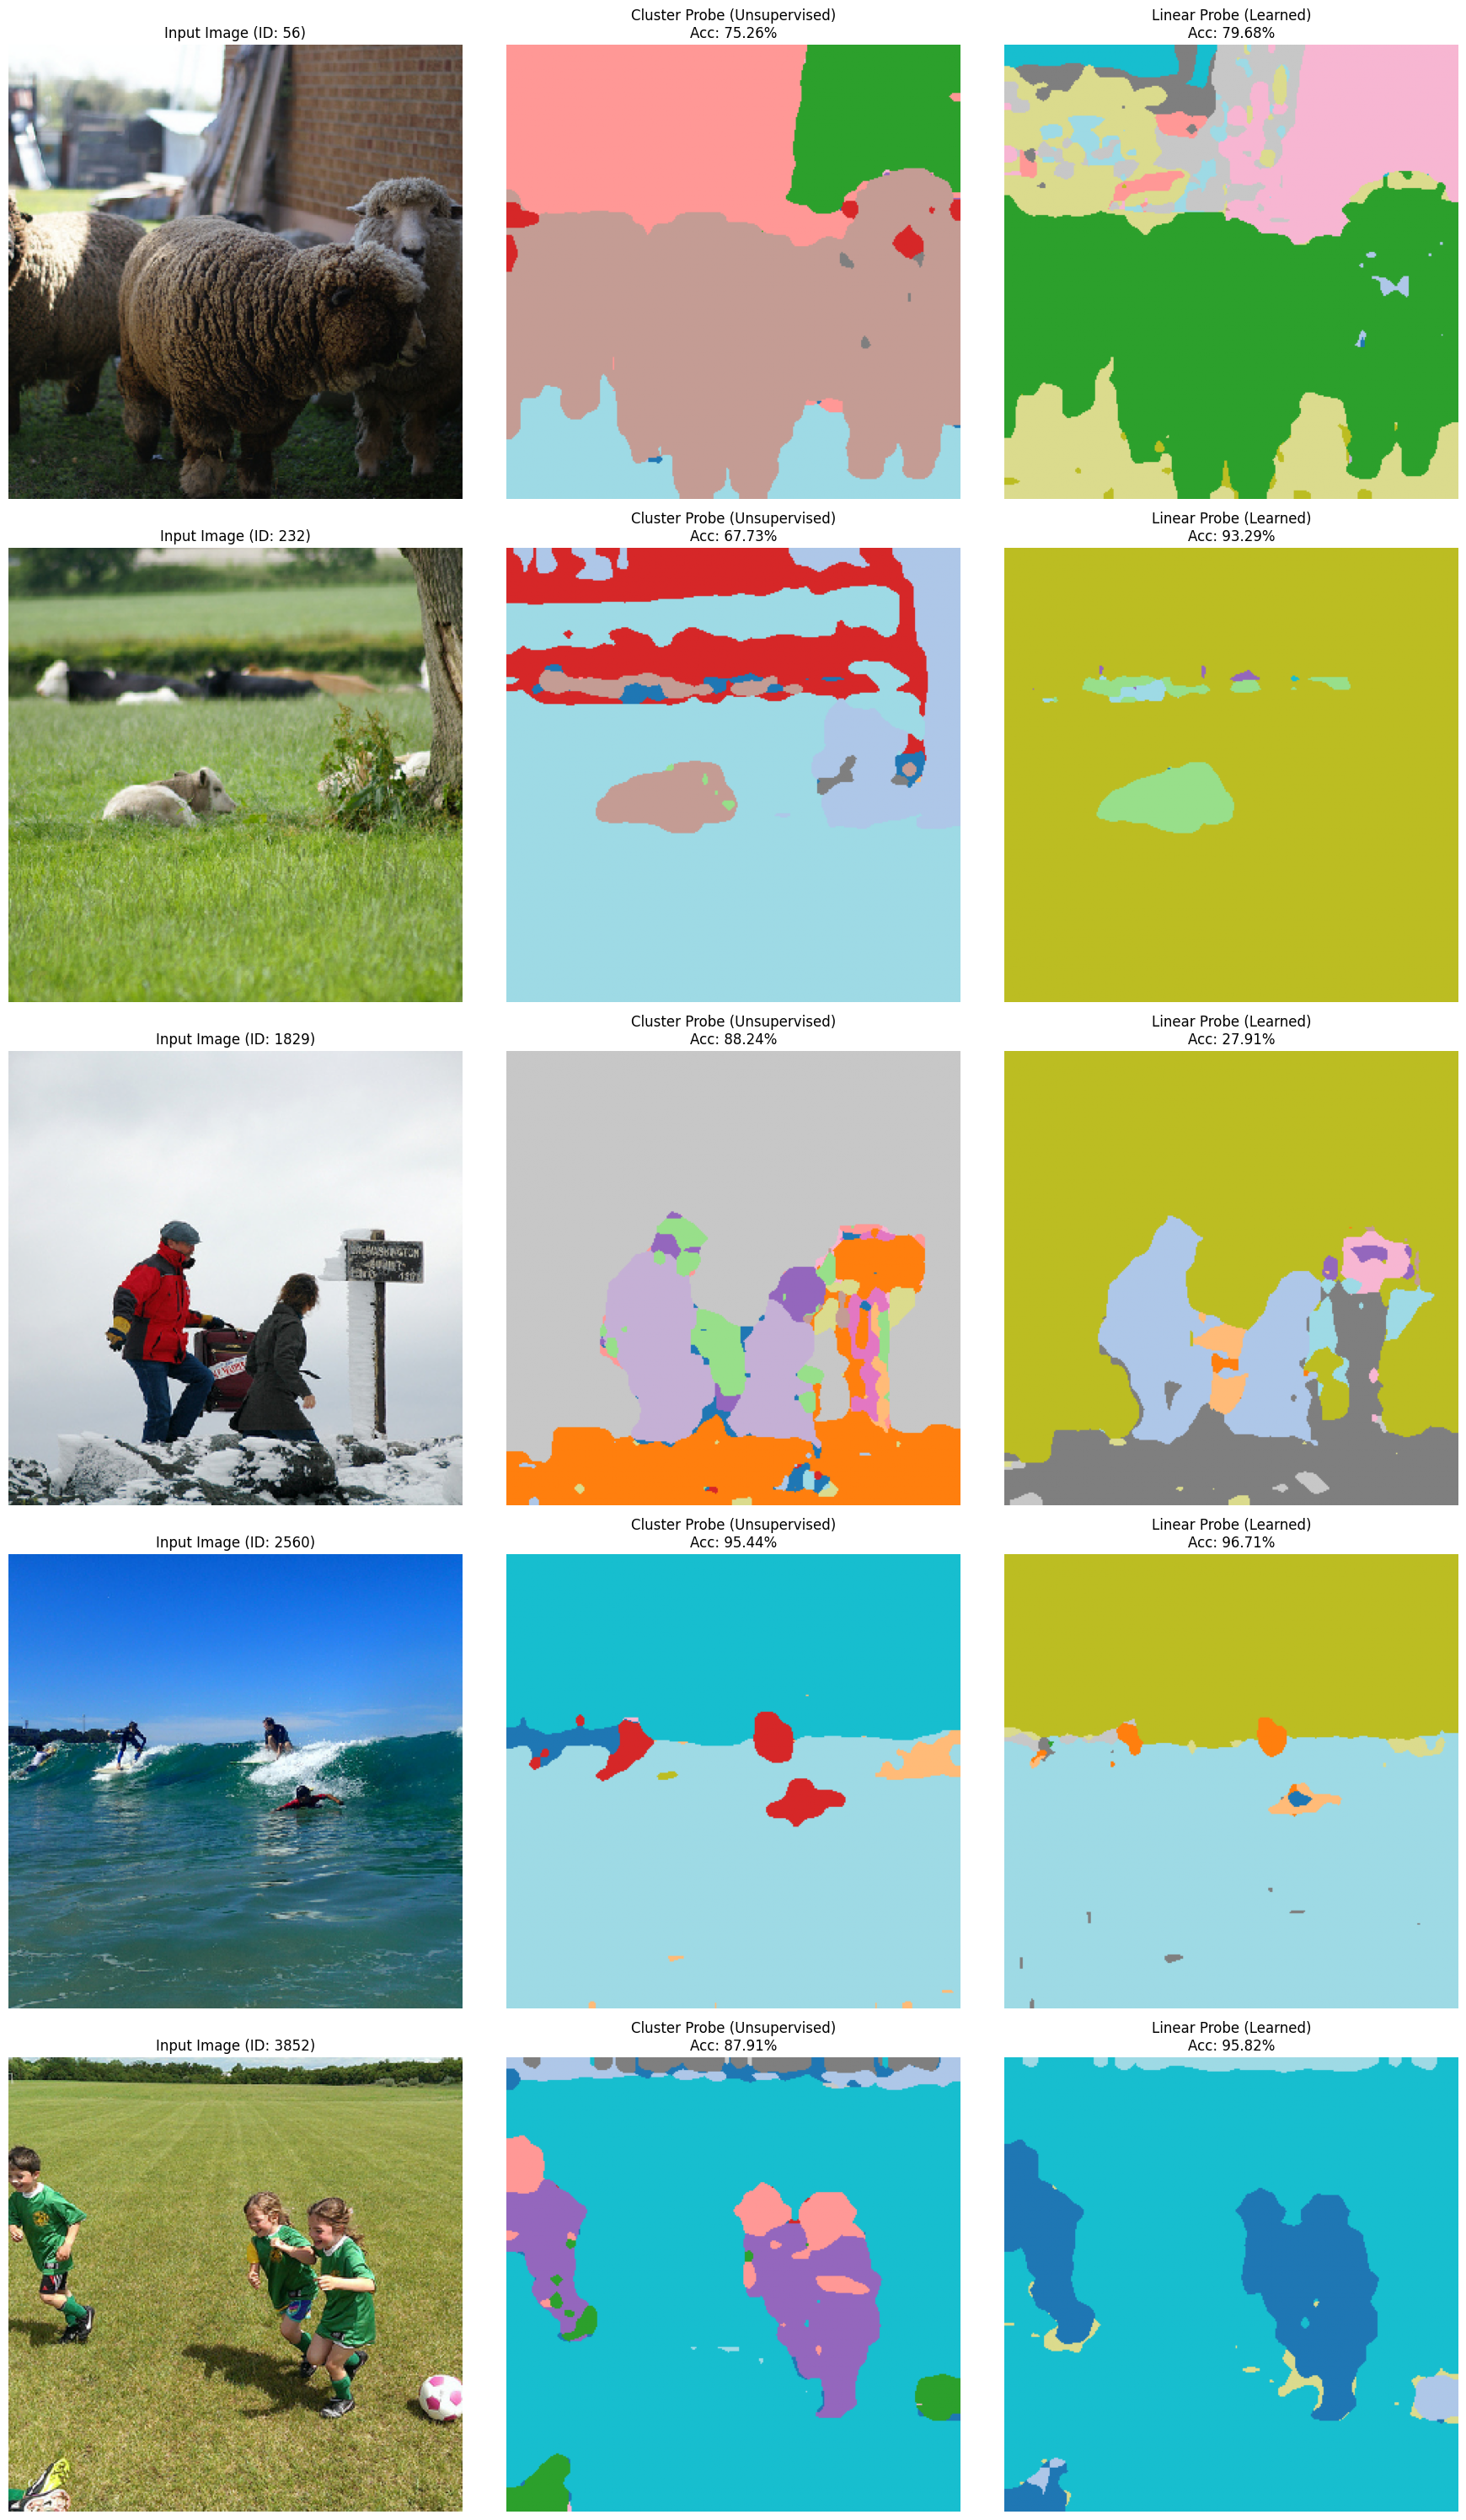

In [10]:
# Step 7: Qualitative Results (Segmentation Visualizations)
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment

def compute_cluster_accuracy(pred, target, num_classes=27):
    """
    Computes accuracy for unsupervised clustering by finding the optimal
    1-to-1 mapping between clusters and ground truth classes (Hungarian Algorithm).
    """
    # Flatten
    pred = pred.flatten()
    target = target.flatten()


    # Compute confusion matrix
    # Rows: Clusters, Cols: GT Classes
    # We need to know the max cluster ID to size the matrix
    max_cluster = pred.max()
    max_class = target.max()

    # Size: (Max Cluster + 1, Max Class + 1)
    # We use a safe size
    conf_matrix = np.zeros((max_cluster + 1, max_class + 1), dtype=np.int64)

    for p, t in zip(pred, target):
        conf_matrix[p, t] += 1

    # Hungarian Matching (Linear Sum Assignment)
    # We want to maximize the sum of diagonal elements (matches)
    # linear_sum_assignment minimizes cost, so we pass negative confusion matrix
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)

    # Calculate accuracy based on optimal assignment
    correct_pixels = conf_matrix[row_ind, col_ind].sum()
    total_pixels = pred.size

    return (correct_pixels / total_pixels) * 100

def visualize_eagle_results(model, dataset, indices, device):
    model.eval()

    # Create figure with 3 columns
    num_images = len(indices)
    fig, axes = plt.subplots(num_images, 3, figsize=(18, 6 * num_images))

    # Handle single image case
    if num_images == 1:
        axes = axes.reshape(1, -1)

    print(f"Generating visualizations for {num_images} images...")

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Get data
            batch = dataset[idx]
            img = batch["img"].unsqueeze(0).to(device)
            label = batch["label"].unsqueeze(0).to(device)

            # Forward pass
            feats, feats_kk, code, code_kk = model.net(img)
            code_kk = F.interpolate(code_kk, label.shape[-2:], mode='bilinear', align_corners=False)

            # --- 1. Cluster Prediction (Unsupervised) ---
            _, cluster_preds = model.cluster_probe(code_kk, None)
            cluster_pred_mask = cluster_preds.argmax(1).cpu().numpy()[0]

            # --- 2. Linear Prediction (Learned) ---
            linear_preds = model.linear_probe(code_kk)
            linear_pred_mask = linear_preds.argmax(1).cpu().numpy()[0]

            # --- 3. Ground Truth ---
            gt_mask = label.cpu().numpy()[0]

            # Linear Accuracy (Direct Match)
            linear_acc = (linear_pred_mask == gt_mask).mean() * 100

            # Cluster Accuracy (Hungarian Match)
            cluster_acc = compute_cluster_accuracy(cluster_pred_mask, gt_mask)

            # Prepare Input Image for display (denormalize)
            mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
            std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)
            img_np = img.cpu().numpy()[0].transpose(1, 2, 0)
            img_np = std * img_np + mean
            img_np = np.clip(img_np, 0, 1)

            # Plotting
            # Col 1: Input Image
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title(f"Input Image (ID: {idx})")
            axes[i, 0].axis('off')

            # Col 2: Cluster Prediction
            axes[i, 1].imshow(cluster_pred_mask, cmap='tab20')
            axes[i, 1].set_title(f"Cluster Probe (Unsupervised)\nAcc: {cluster_acc:.2f}%")
            axes[i, 1].axis('off')

            # Col 3: Linear Prediction
            axes[i, 2].imshow(linear_pred_mask, cmap='tab20')
            axes[i, 2].set_title(f"Linear Probe (Learned)\nAcc: {linear_acc:.2f}%")
            axes[i, 2].axis('off')

            print(f" Processed image {i+1}/{num_images} (index {idx}) - Cluster Acc: {cluster_acc:.2f}%, Linear Acc: {linear_acc:.2f}%")

    plt.tight_layout()
    plt.show()

# Select specific images to visualize
test_indices = [56, 232, 1829, 2560, 3852]

visualize_eagle_results(model, val_dataset, test_indices, device)